# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [4]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

def sd_num(h5_data):
    ydict = yaml.safe_load(h5_data.attrs['RunConfig'])
    return ydict['rngSeed']

  0%|          | 0/6 [00:00<?, ?it/s]

0.0


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


82.66666666666667
165.33333333333334
248.0
330.6666666666667
413.33333333333337


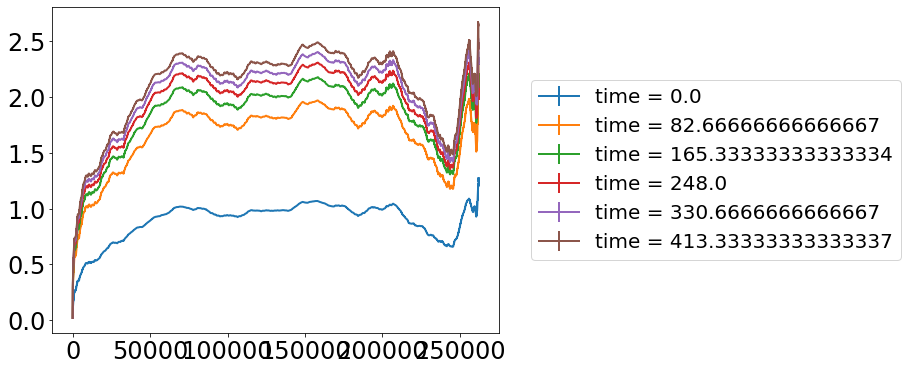

In [ ]:
data_path = (ceph_path / '22-07-06_aLc1_line262144_hilbert_confRad3um_256')
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, ax = plt.subplots(figsize=(8,6))
data_list = [] 
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    for time_ind in tqdm(np.arange(0, time_arr.size, time_arr.size/6)):
        print(time_ind)
        sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, time_ind]
        com_arr = .5 * (sy_dat[:, 2:5] + sy_dat[:, 5:8])
        avg_dist_arr = np.zeros(com_arr.shape[0]-1) 
        avg_dist_sem_arr = np.zeros(com_arr.shape[0]-1)
        for i in range(1, com_arr.shape[0]):
            dist_arr = np.linalg.norm(com_arr[i:] - com_arr[:-i], axis=-1)
            avg_dist_arr[i-1] = dist_arr.mean()
            avg_dist_sem_arr[i-1] = stats.sem(dist_arr)
            
        _ = ax.errorbar(np.arange(avg_dist_arr.size)+1, avg_dist_arr, yerr=avg_dist_sem_arr, label=f'time = {time_ind}')
        data_list += [{'avg_dist': avg_dist_arr,
                       'avg_dist_sem_arr': avg_dist_sem_arr,
                       'time': time_ind,
        }]
        

_ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Cluster size and volume characterization

/tmp/ipykernel_2784479/1479522363.py:36: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')


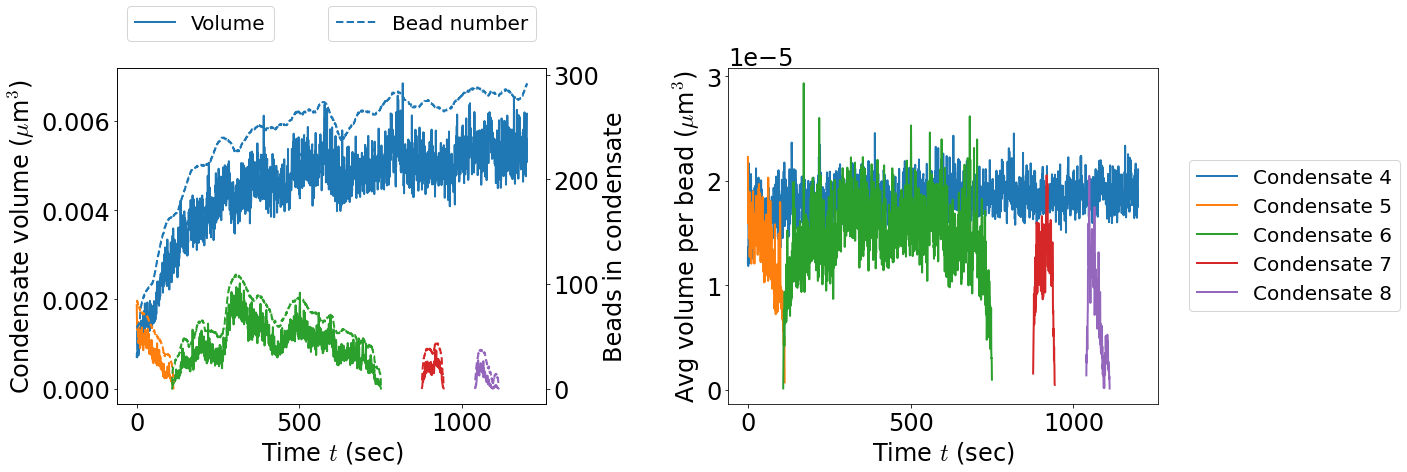

In [53]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s5")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

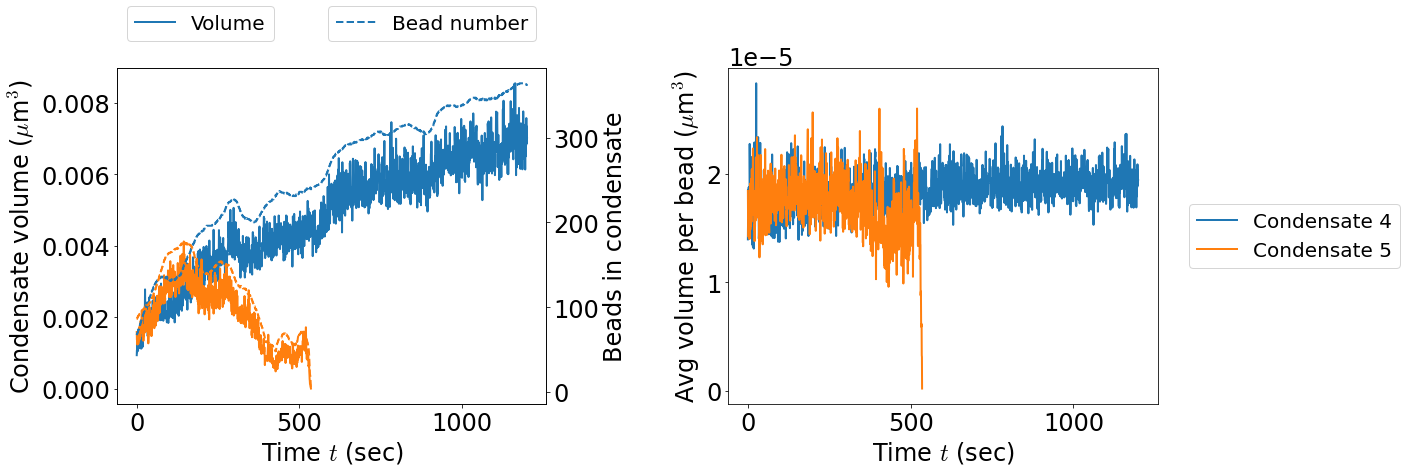

In [54]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

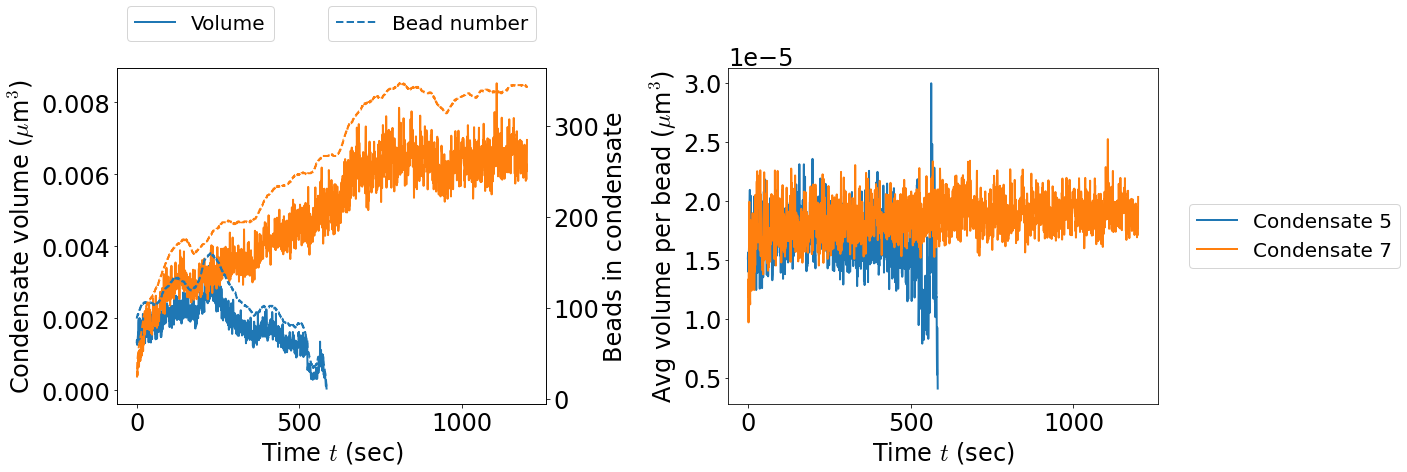

In [55]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s20")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

In [1]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.04")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

for h5_file in data_path.glob('*/analysis/*.h5'):
    with h5py.File(h5_file, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:end_ind]
        analysis_grp = h5_data['analysis']

        sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        largest_cond = 0
        for ci, cond_str in enumerate(h5_data['analysis/condensates']):
            cond_data = h5_data[f'analysis/condensates/{cond_str}']
            max_cond_size = np.max(cond_data[:,2] -cond_data[:, 1])
            if max_cond_size < largest_cond:
                continue
            largest_cond = max_cond_size
            cond_time = cond_data[:,0]
            # print(cond_data)
            volume_arr = np.zeros(cond_data.shape[0])
            bead_arr = np.zeros(cond_data.shape[0])
            for i, cdat in enumerate(cond_data):
                t = np.where(time_arr == cdat[0])[0][0]
                parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
                if parts.shape[0] < 4:
                    continue
                hull = ConvexHull(parts)
                volume_arr[i] = hull.volume
                bead_arr[i] = parts.shape[0]
            
        _ = axarr[0].plot(cond_time, volume_arr)
        _ = axarr0.plot(cond_time, bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
        _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])

    _ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
    _ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
    _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    for ax in axarr:
        _ = ax.set_xlabel('Time $t$ (sec)')
    _ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
    _ = axarr0.set_ylabel('Beads in condensate')
    _ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

NameError: name 'ceph_path' is not defined

## Contact correlation

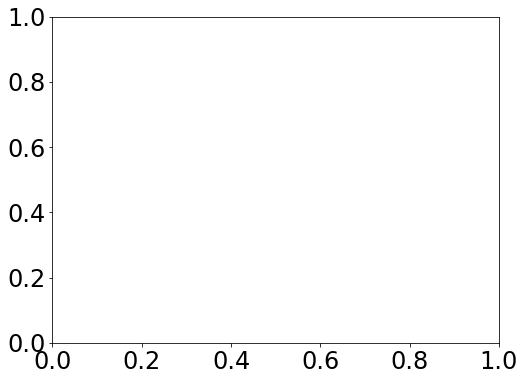

In [9]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s1/")
ss_ind = -500
end_ind = None
start_bead = 0
end_bead = None

# fig, axarr = plt.subplots(1,2, figsize=(20, 7))
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :,:] - com_arr[np.newaxis, :, :,:], axis=2)
    
        

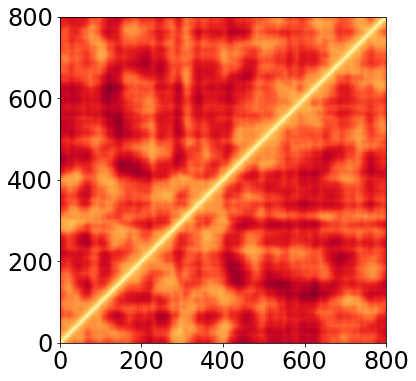

In [24]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

axarr.set_aspect('equal')
avg_mat = sep_mat.mean(axis=-1)
x = range(sep_mat.shape[0]+1)
X, Y = np.meshgrid(x, x)

axarr.pcolorfast(X,Y,avg_mat, shading='auto')


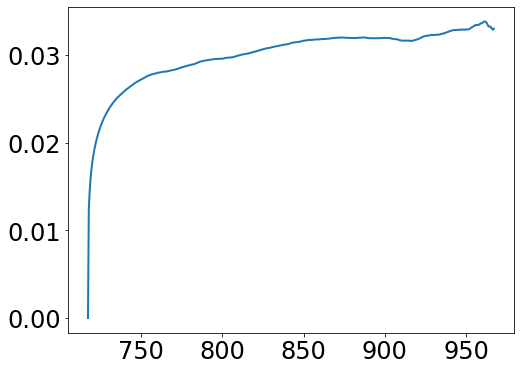

In [28]:
n = sep_mat.shape[0]
Ttot = sep_mat.shape[-1]
corr_d = np.zeros(sep_mat.shape[-1])
for i in tqdm(range(1,sep_mat.shape[-1])):
    corr_d[i] = np.sum(np.abs(sep_mat[:,:,i:] - sep_mat[:,:,:-i]))/(2.*n*(n-1.)*(Ttot-i))

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
axarr.plot(time_arr, corr_d)


  0%|          | 0/499 [00:00<?, ?it/s]

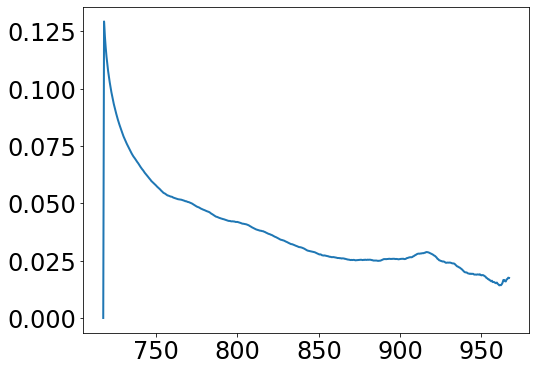

In [49]:
data_path = (
    ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s1/")
ss_ind = -500
end_ind = None
start_bead = 0
end_bead = None

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

n = sep_mat.shape[0]
Ttot = sep_mat.shape[-1]
corr_d = np.zeros(sep_mat.shape[-1])
avg_sep_mat = sep_mat.mean(axis=(0,1))
avg_sep = avg_sep_mat.mean()
for i in tqdm(range(1,sep_mat.shape[-1])):
    corr_d[i] = np.sum((sep_mat[:,:,i:] - avg_sep_mat[i:]) * (sep_mat[:,:,:-i]-avg_sep_mat[:-i]))/(n*n*avg_sep*avg_sep*(Ttot-i))

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
axarr.plot(time_arr, corr_d)


  0%|          | 0/499 [00:00<?, ?it/s]

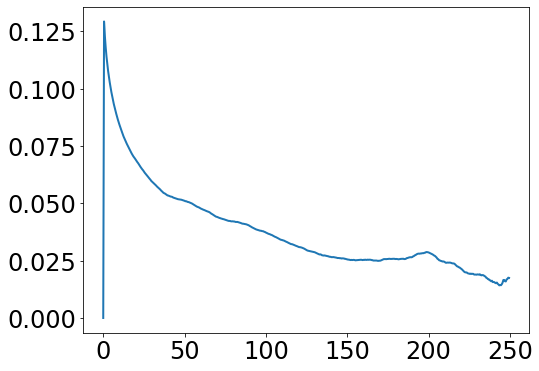

In [53]:
import torch
data_path = (
    ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s1/")
# ss_ind = -500
# end_ind = None
ss_ind = 1
end_ind = 501
start_bead = 0
end_bead = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

n = sep_mat.shape[0]
Ttot = sep_mat.shape[-1]
tsep_mat = torch.from_numpy(sep_mat).to(device)
corr_d = torch.zeros(sep_mat.shape[-1], device=device)
avg_sep_mat = torch.from_numpy(sep_mat.mean(axis=(0,1))).to(device)
avg_sep = avg_sep_mat.mean()
for i in tqdm(range(1,sep_mat.shape[-1])):
    corr_d[i] = ((tsep_mat[:,:,i:] - avg_sep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_sep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
axarr.plot(time_arr, corr_d.cpu())


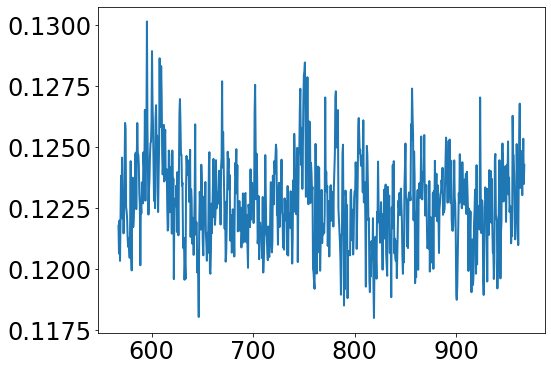

In [37]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s1/")
ss_ind = -800
end_ind = None
start_bead = 0
end_bead = None

# fig, axarr = plt.subplots(1,2, figsize=(20, 7))
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
rog = aa.calc_rad_of_gyration(com_arr)
axarr.plot(time_arr, rog)


  0%|          | 0/799 [00:00<?, ?it/s]

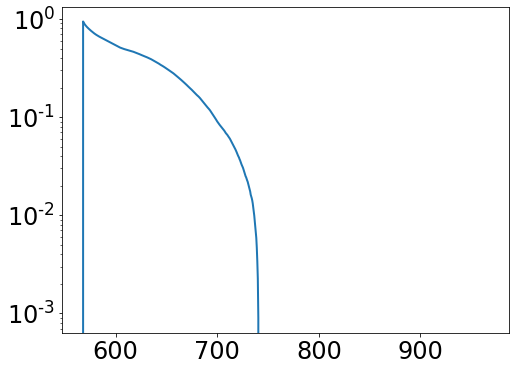

In [41]:
def poly_autocorr(com_arr):
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = com_arr.mean(axis=0)
    autocorr = np.zeros(Ttot)
    avg_rog = np.average(aa.calc_rad_of_gyration(com_arr))
    for i in range(1,Ttot):
        autocorr[i] = np.einsum('ijk,ijk->',
                                com_arr[:,:,i:] - pol_com[:,i:], 
                                com_arr[:,:,:-i] - pol_com[:,:-i])/((Ttot-i)*(avg_rog*avg_rog)*n)
    return autocorr

ac = poly_autocorr(com_arr)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
axarr.plot(time_arr, ac)
axarr.set_yscale('log')

# Large simulations

## Free polymer

In [31]:
data_path = (ws_path / "22-07-12_aLc1_line16000_sticky_100um")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/22*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = (data_path / 'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]



(2401,)


2400


/tmp/ipykernel_2998629/2863863724.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axarr.pcolor(T,X, hists.T)


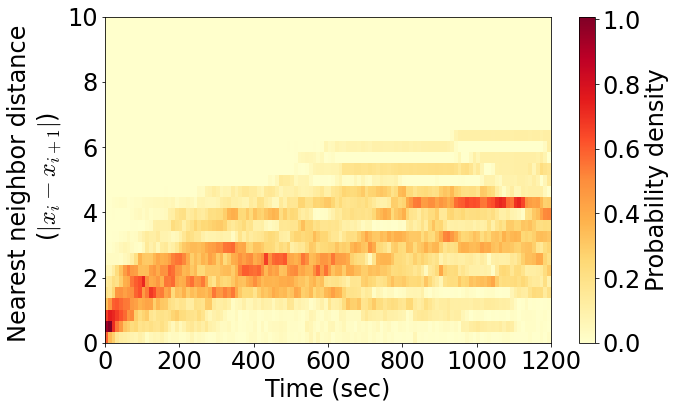

In [7]:
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

N = 20 # Number of time snapshots in grouping
sep_arr_list = []
print(len(clusters))
for i in range(0, len(clusters), N):
    # Step through time grouped clusters and collect centers
    cluster_centers = []
    for j in range(N):
        # Sort the clusters by the x-distance so you know that each cluster
        # is in order by nearest neighbors
        time_grp = sorted(clusters[i+j], key=lambda x: x.center[0])
        cluster_centers += [c.center for c in time_grp] 
    cluster_centers = np.array(cluster_centers)
    # Distance between cluster centers of nearest neighbors 
    
    sep_arr = cluster_centers[1:, 0] - cluster_centers[:-1, 0] 
    sep_arr_list += [sep_arr]

max_dist = 10
nbins = 30
hists = np.zeros((len(sep_arr_list), nbins)) 
for i, seps in enumerate(sep_arr_list):
    hists[i], bin = np.histogram(seps, bins=nbins, range=(0, max_dist),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_dist, nbins))
c = axarr.pcolor(T,X, hists.T)
cbar = fig.colorbar(c, ax=axarr, label='Probability density')
    

_ = axarr.set_ylabel("Nearest neighbor distance \n ($|x_i - x_{i+1}|$)") 
_ = axarr.set_xlabel("Time (sec)")

/tmp/ipykernel_2998629/2584167721.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c0 = axarr[0].pcolor(T,X, hists.T)
/tmp/ipykernel_2998629/2584167721.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c1 = axarr[1].pcolor(T,X, dens_hists.T)


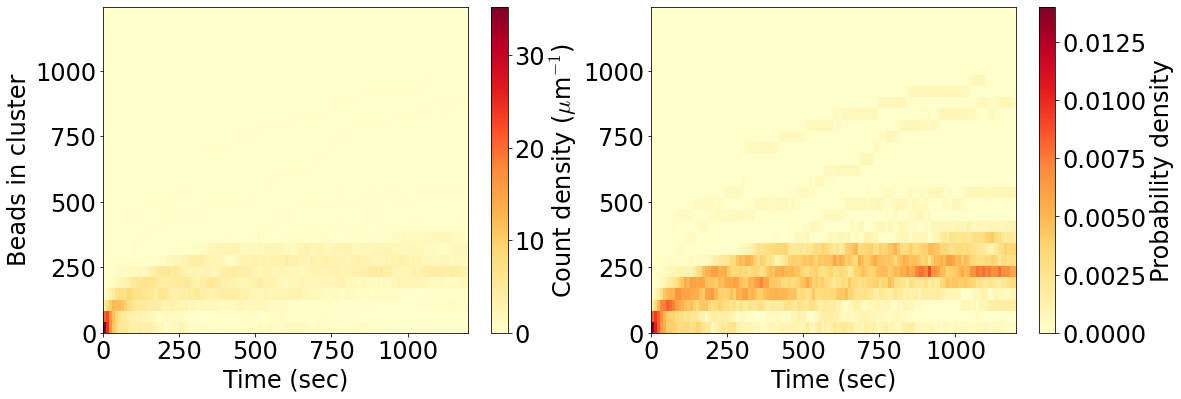

In [8]:
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

N = 20 # Number of time snapshots in grouping
cluster_size_list = []
for i in range(0, len(clusters), N):
    # Step through time grouped clusters and collect centers
    cluster_sizes = []
    for j in range(N):
        # Sort the clusters by the x-distance so you know that each cluster
        # is in order by nearest neighbors
        cluster_sizes += [len(c.part_ids) for c in clusters[i+j]] 
    # Distance between cluster centers of nearest neighbors 
    
    cluster_size_list += [cluster_sizes]


max_size = max([max(cs) for cs in cluster_size_list])
nbins = 30
hists = np.zeros((len(cluster_size_list), nbins)) 
dens_hists = np.zeros((len(cluster_size_list), nbins)) 
for i, cs in enumerate(cluster_size_list):
    hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)
    hists[i] *= len(cs)
    dens_hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_size, nbins))
c0 = axarr[0].pcolor(T,X, hists.T)
c1 = axarr[1].pcolor(T,X, dens_hists.T)
cbar0 = fig.colorbar(c0, ax=axarr[0], label='Count density ($\mu$m$^{-1}$)')
cbar1 = fig.colorbar(c1, ax=axarr[1], label='Probability density')

_ = axarr[0].set_ylabel("Beads in cluster") 
_ = axarr[0].set_xlabel("Time (sec)")
_ = axarr[1].set_xlabel("Time (sec)")

In [ ]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

451936


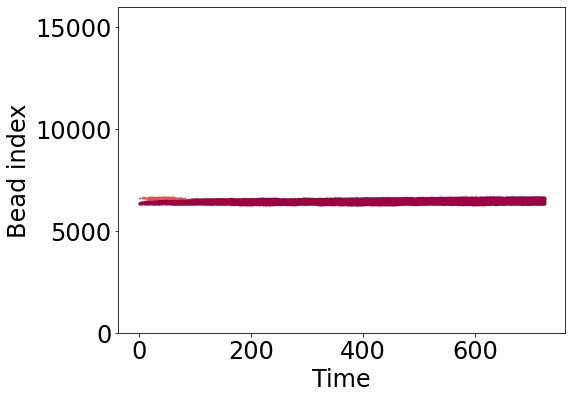

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,16000)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
print(biggest_tree.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(branch_roots))]
for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [ ]:
# This could take a long time to run. There is a probably a way to do this faster
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
colors = [plt.cm.Spectral(tree) for tree in np.linspace(0, 1, len(trees))]
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

## Pinned filament condensate analysis

In [33]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/22*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = (data_path / 'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]



(1450,)


1449


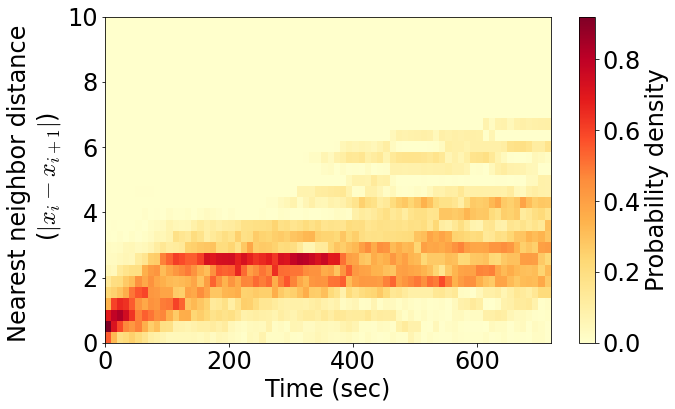

In [25]:
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

N = 20 
sep_arr_list = []
print(len(clusters))
for i in range(0, len(clusters)-N, N):
    cluster_centers = []
    for j in range(N):
        time_grp = sorted(clusters[i+j], key=lambda x: x.center[0])
        cluster_centers += [c.center for c in time_grp] 
    cluster_centers = np.array(cluster_centers)
    sep_arr = cluster_centers[1:, 0] - cluster_centers[:-1, 0] 
    sep_arr_list += [sep_arr]
    # sep_arr = np.concatenate((sep_arr, np.abs(np.diagonal(sep_mat,1))))

max_dist = 10
nbins = 30
hists = np.zeros((len(sep_arr_list), nbins)) 
for i, seps in enumerate(sep_arr_list):
    hists[i], bin = np.histogram(seps, bins=nbins, range=(0, max_dist),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_dist, nbins))
c = axarr.pcolor(T,X, hists.T)
cbar = fig.colorbar(c, ax=axarr, label='Probability density')
    

_ = axarr.set_ylabel("Nearest neighbor distance \n ($|x_i - x_{i+1}|$)") 
_ = axarr.set_xlabel("Time (sec)")

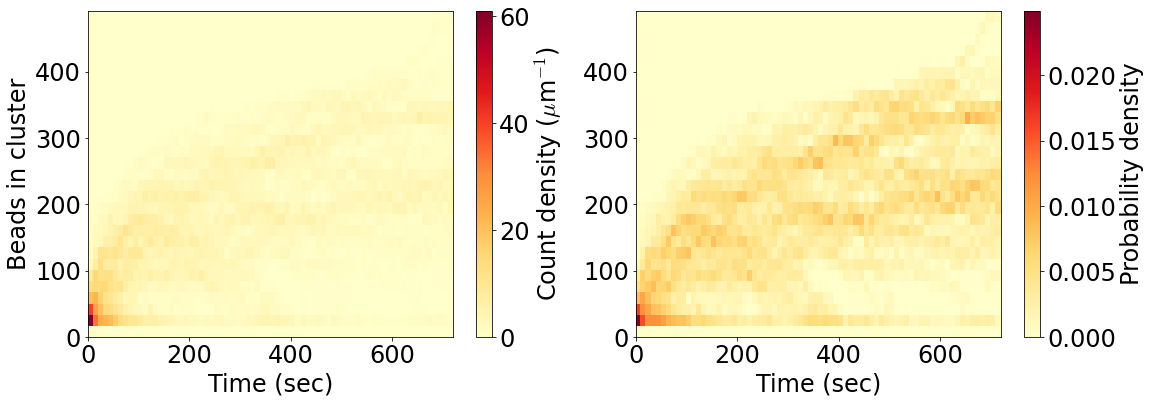

In [27]:
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

N = 20 # Number of time snapshots in grouping
cluster_size_list = []
for i in range(0, len(clusters), N):
    # Step through time grouped clusters and collect centers
    cluster_sizes = []
    for j in range(N):
        if i+j >= len(clusters):
            break
        # Sort the clusters by the x-distance so you know that each cluster
        # is in order by nearest neighbors
        cluster_sizes += [len(c.part_ids) for c in clusters[i+j]] 
    # Distance between cluster centers of nearest neighbors 
    
    cluster_size_list += [cluster_sizes]


max_size = max([max(cs) for cs in cluster_size_list])
nbins = 30
hists = np.zeros((len(cluster_size_list), nbins)) 
dens_hists = np.zeros((len(cluster_size_list), nbins)) 
for i, cs in enumerate(cluster_size_list):
    hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)
    hists[i] *= len(cs)
    dens_hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_size, nbins))
c0 = axarr[0].pcolor(T,X, hists.T)
c1 = axarr[1].pcolor(T,X, dens_hists.T)
cbar0 = fig.colorbar(c0, ax=axarr[0], label='Count density ($\mu$m$^{-1}$)')
cbar1 = fig.colorbar(c1, ax=axarr[1], label='Probability density')

_ = axarr[0].set_ylabel("Beads in cluster") 
_ = axarr[0].set_xlabel("Time (sec)")
_ = axarr[1].set_xlabel("Time (sec)")

In [14]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

451936


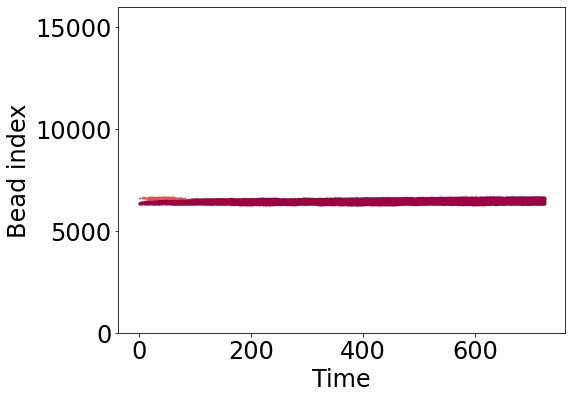

In [15]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,16000)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
print(biggest_tree.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(branch_roots))]
for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [16]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
colors = [plt.cm.Spectral(tree) for tree in np.linspace(0, 1, len(trees))]
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

## Sticky patch free polymer

In [27]:
data_path = (ceph_path /"22-07-12_aLc1_line16000_sticky_100um_patch1e3")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/22*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = (data_path / 'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]



(1649,)


1648


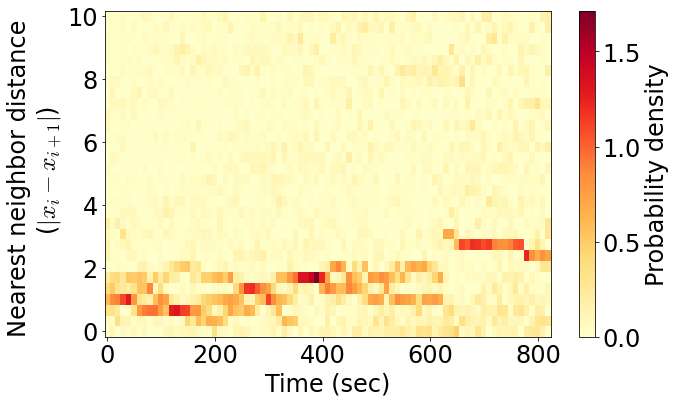

In [32]:
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

N = 20 
sep_arr_list = []
print(len(clusters))
for i in range(0, len(clusters), N):
    cluster_centers = []
    for j in range(N):
        if i+j >= len(clusters):
            break
        time_grp = sorted(clusters[i+j], key=lambda x: x.center[0])
        cluster_centers += [c.center for c in time_grp] 

    cluster_centers = np.array(cluster_centers)
    sep_arr = cluster_centers[1:, 0] - cluster_centers[:-1, 0] 
    sep_arr_list += [sep_arr]

max_dist = 10
nbins = 30
hists = np.zeros((len(sep_arr_list), nbins)) 
for i, seps in enumerate(sep_arr_list):
    hists[i], bin = np.histogram(seps, bins=nbins, range=(0, max_dist),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_dist, nbins))
c = axarr.pcolor(T,X, hists.T, shading='nearest')
cbar = fig.colorbar(c, ax=axarr, label='Probability density')
    

_ = axarr.set_ylabel("Nearest neighbor distance \n ($|x_i - x_{i+1}|$)") 
_ = axarr.set_xlabel("Time (sec)")

In [ ]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

451936


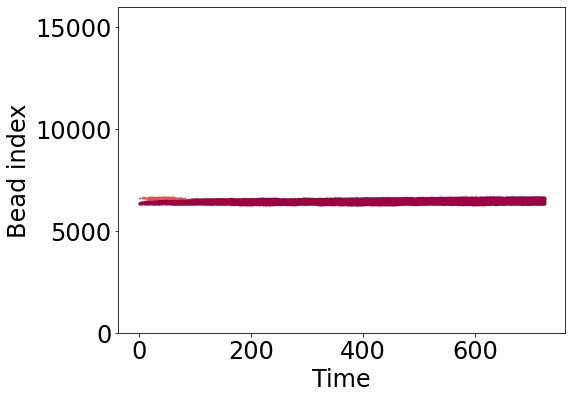

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,16000)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
print(biggest_tree.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(branch_roots))]
for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
colors = [plt.cm.Spectral(tree) for tree in np.linspace(0, 1, len(trees))]
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

/tmp/ipykernel_3456393/353349454.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axarr[1,0].pcolor(X, Y, bead_ind_arr)


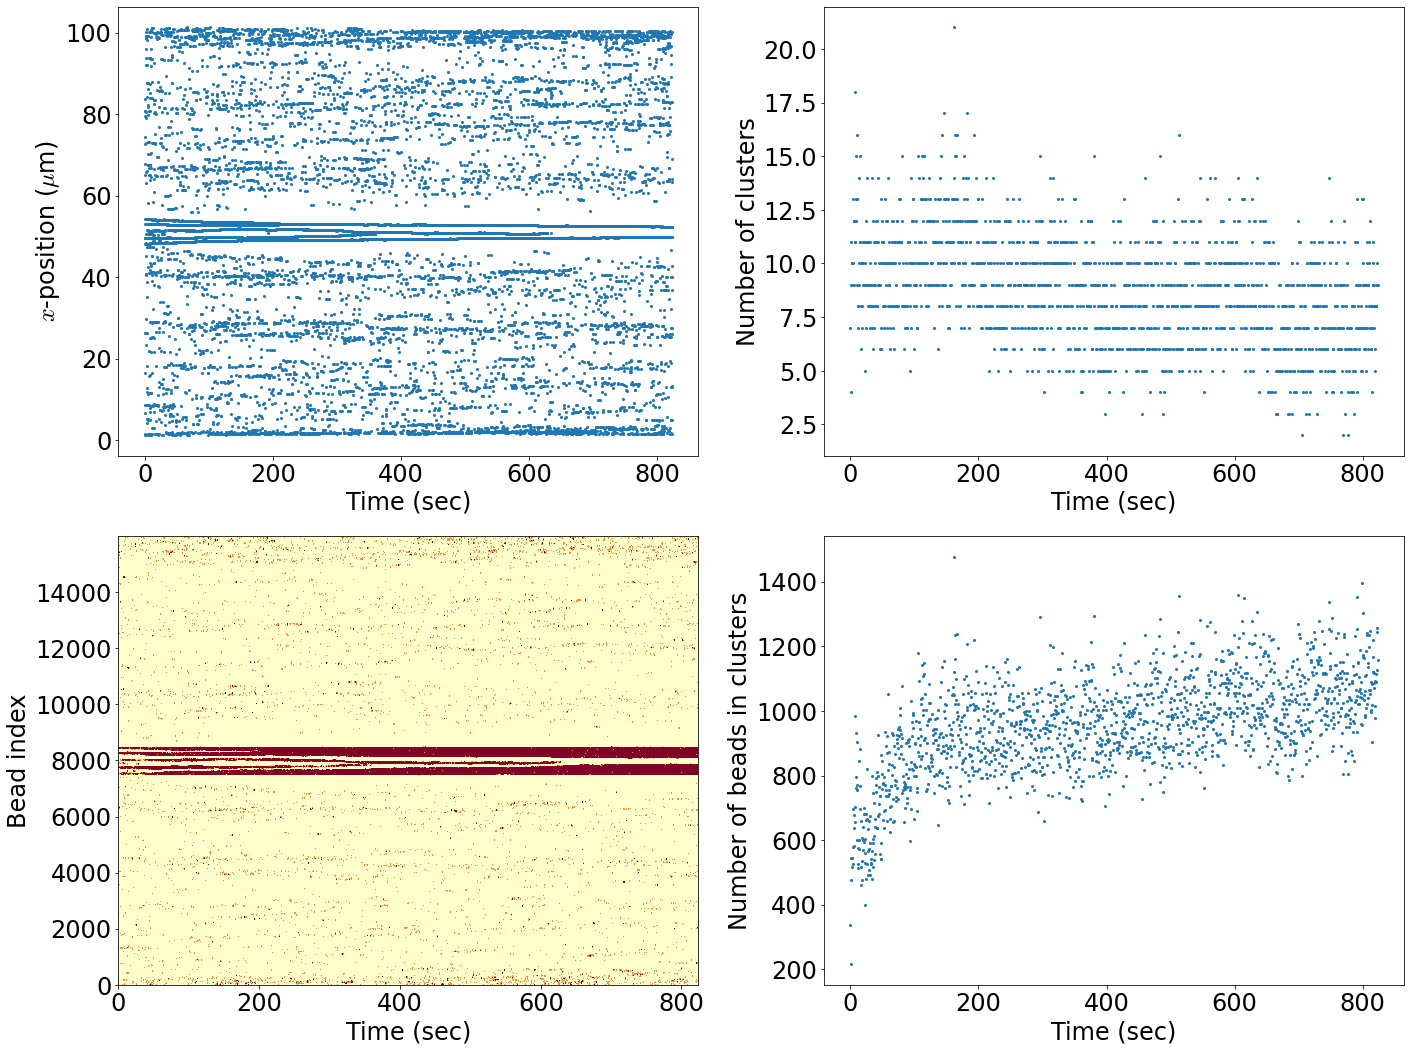

In [10]:
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []

for c, clust_grp in enumerate(clusters):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        if len(clust.part_ids) > 20:
            flat_time_arr += [clust.time]
            flat_clust_cent_arr += [clust.center]
            flat_clust_ind_arr += [clust.part_ids]
            num_beads += len(clust.part_ids)

    num_cluster_beads_list += [num_beads]
    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    for clust in clust_grp:
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5


fig, axarr = plt.subplots(2,2, figsize=(20, 15))
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
c = axarr[1,0].pcolor(X, Y, bead_ind_arr)

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr[:-1], num_clusters_list)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr[:-1], num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()